## Output has been removed from this notebook to reduce file sizes in the repo

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pandana as pdna
from pandana.loaders import osm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Download OpenStreetMap restaurants for a good part of the Bay Area

###### Note: used http://boundingbox.klokantech.com/ to get the bounding box

In [3]:
# Bounding box from link above

# CSV for Aveiro
bbox = [-8.440762,39.966859,-8.305836,40.049563]
bbox = [bbox[1], bbox[0], bbox[3], bbox[2]]

network = osm.pdna_network_from_bbox(*bbox)
poi_df = osm.node_query(*bbox, tags='amenity=school')
x, y = poi_df['lon'], poi_df['lat']
# store = poi_df.


Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](39.96685900,-8.44076200,40.04956300,-8.30583600);>;);out;'}"
Downloaded 1,987.2KB from www.overpass-api.de in 0.72 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 0.87 seconds
Returning OSM data with 18,657 nodes and 845 ways...
Edge node pairs completed. Took 2.96 seconds
Returning processed graph with 1,063 nodes and 1,478 edges...
Completed OSM data download and Pandana node and edge table creation in 4.37 seconds


In [4]:
poi_df.head()

,lat,lon,amenity,name,addr:city,addr:housenumber,addr:postcode,addr:street,phone,website,wheelchair
id,,,,,,,,,,,
4088872856,40.026197,-8.387371,school,Escola Básica Infante D. Pedro,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4088885304,40.026838,-8.388275,school,Cerci Penela,Penela,3,3230-268,Avenida Infante D. Pedro,+351 239 560 140,www.cercipenela.org.pt,yes
5265667397,40.011174,-8.352745,school,Escola Básica de Espinhal,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:

network.set_pois('schools', 2000, 10, x,y)
network.save_hdf5('data/aveiro3.h5')
# x, y = poi_df['lon'], poi_df['lat']


## Get previously stored OpenStreetMap networks for Bay Area

Download the data here: https://s3-us-west-1.amazonaws.com/synthpop-data2/pandana/osm_bayarea.h5

In [7]:
store = pd.HDFStore('data/aveiro3.h5', "r")
# store = network
nodes = store.nodes
edges = store.edges

## Initialize and preprocess the network

In [8]:
net=pdna.Network(nodes.x, 
                 nodes.y, 
                 edges["from"], 
                 edges["to"],
                 edges[["distance"]])
net.precompute(2000)

## Nearest *point-of-interest* queries

In [9]:

net.set_pois("schools", 2000, 3, x, y)

In [10]:
a = net.nearest_pois(2000, "schools", num_pois=3)
a.head(10)

,1,2,3
id,,,
434472010,2000.000000,2000.000000,2000.0
434514966,1958.770996,2000.000000,2000.0
434514968,1982.464966,2000.000000,2000.0
434525812,745.390015,907.155029,2000.0
434525818,747.478027,909.242981,2000.0
434546197,724.325989,886.091003,2000.0
434546198,727.366028,889.130981,2000.0
434558200,2000.000000,2000.000000,2000.0
434558201,2000.000000,2000.000000,2000.0


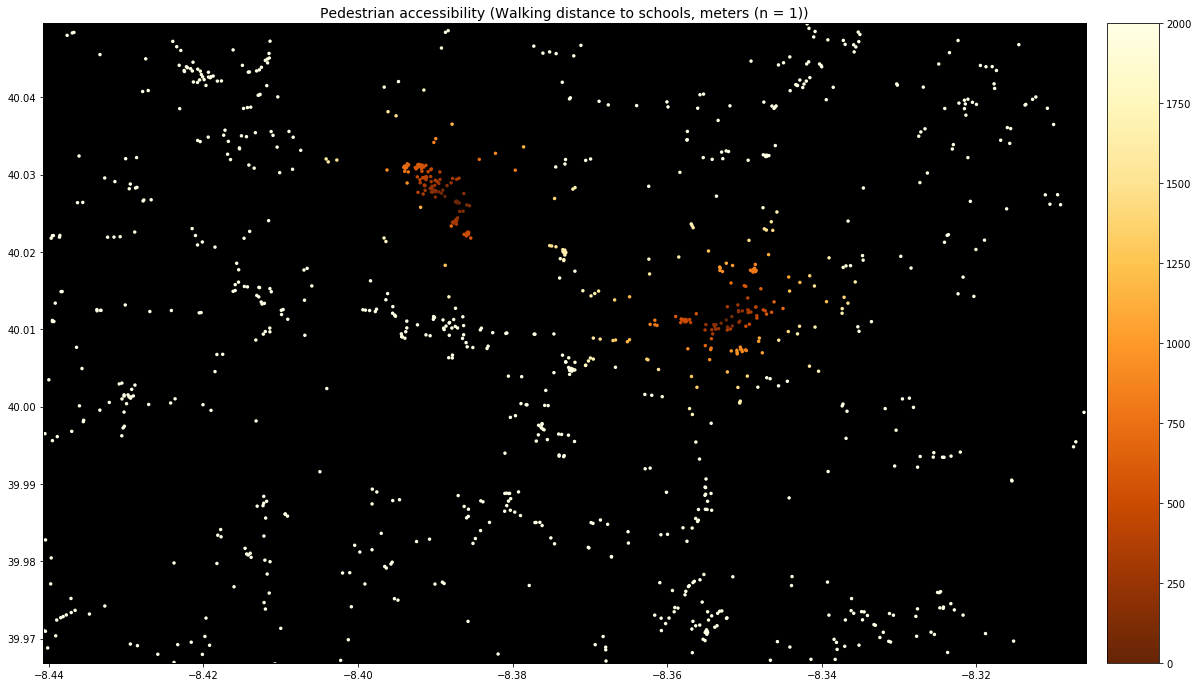

In [15]:
def plot_nearest_amenity(amenity,accessibility, n):
    fig_kwargs = {'figsize': [20, 20]}
    bmap_kwargs = {'suppress_ticks': False, 'resolution': 'h', 'epsg': '4326'}
    plot_kwargs = {'cmap': 'YlOrBr_r', 's': 12, 'edgecolor': 'none'}
    bmap,fig, ax = network.plot(accessibility[n], bbox=bbox,
                               fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)
    ax.set_facecolor('k')
    ax.set_title('Pedestrian accessibility (Walking distance to {}, meters (n = {}))'.format(amenity,n), fontsize=14);

plot_nearest_amenity('schools',a,1)

## Here's a map of the distance to the 5th nearest restaurant

(<mpl_toolkits.basemap.Basemap at 0x7fd4414a43c8>,
 <Figure size 2880x2160 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd440bf09e8>)

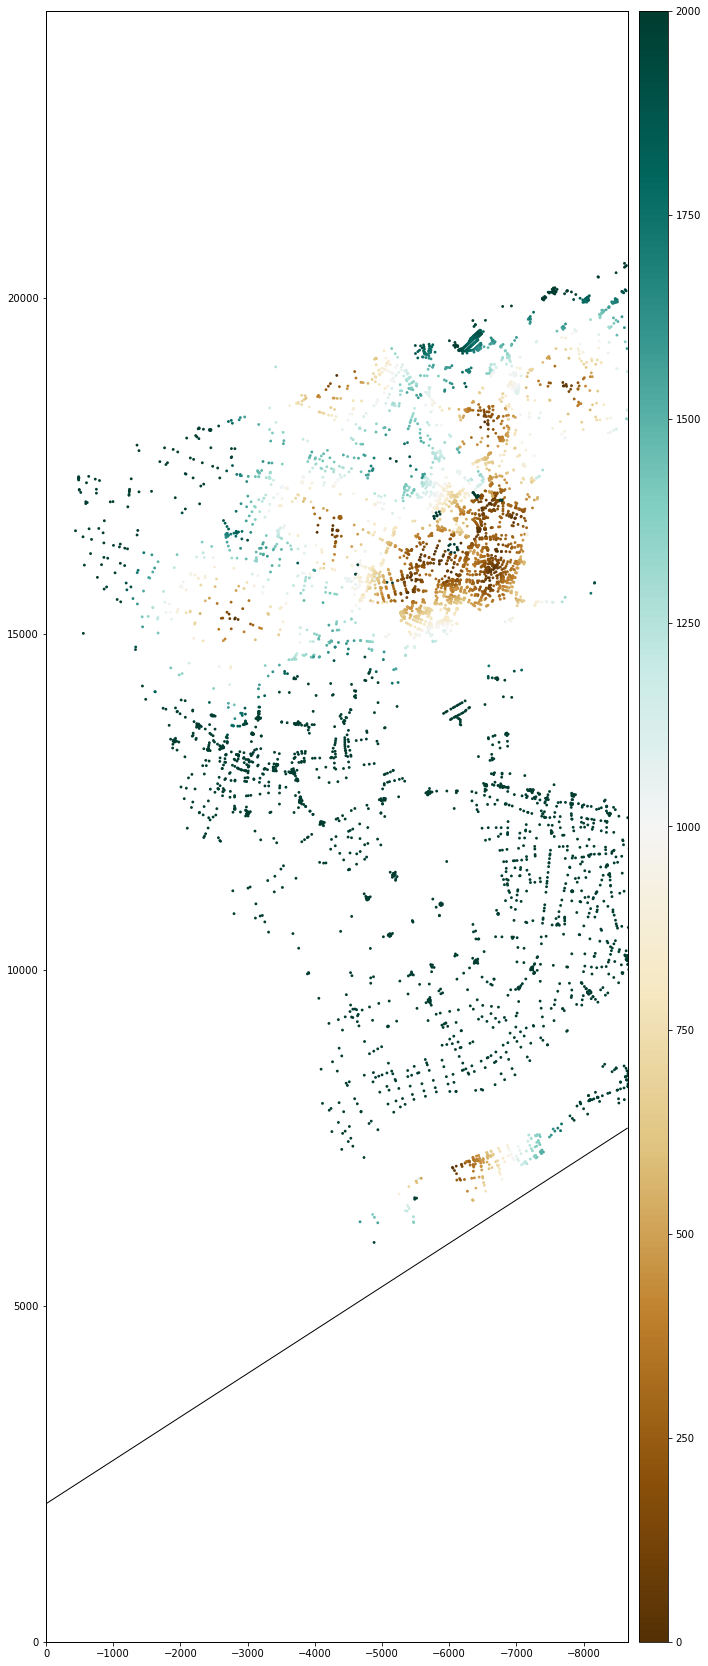

In [10]:
net.plot(a[1], bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Here's a map of the distance to the 10th nearest restaurant

(<mpl_toolkits.basemap.Basemap at 0x7fd4426022e8>,
 <Figure size 2880x2160 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd44250b198>)

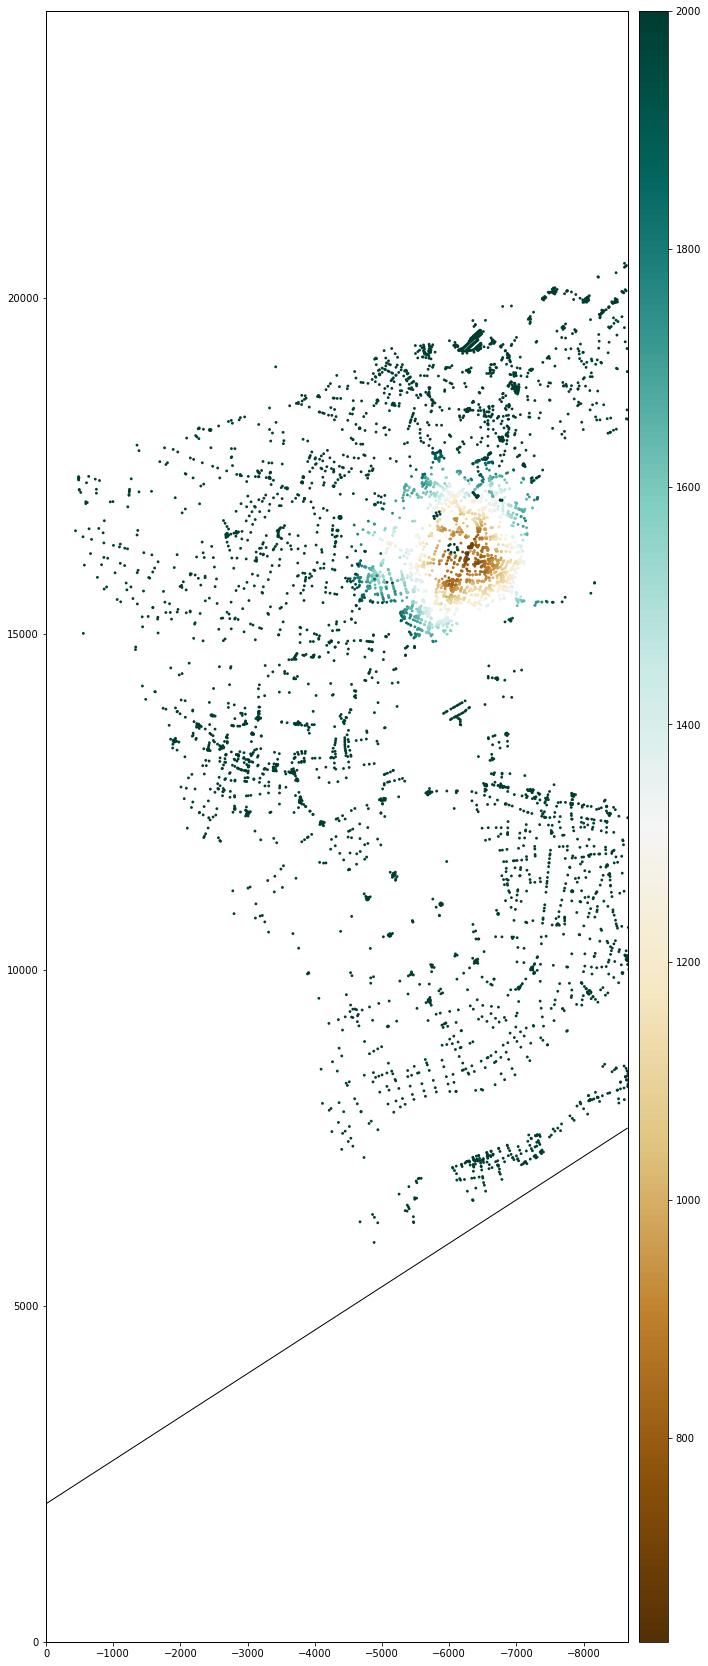

In [11]:
net.plot(a[10], bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

# A similar workflow is used to do general network aggregations

## Relate the x-ys to nodes

In [12]:
node_ids = net.get_node_ids(x, y)

## Assign the variable (in this case just location) to the network

In [13]:
net.set(node_ids)

## This is it - run the queries!

In [14]:
%time s = net.aggregate(500, type="sum", decay="linear")
%time t = net.aggregate(1000, type="sum", decay="linear")
%time u = net.aggregate(2000, type="sum", decay="linear")
%time v = net.aggregate(3000, type="sum", decay="linear")
%time w = net.aggregate(3000, type="count", decay="flat")

CPU times: user 82.8 ms, sys: 0 ns, total: 82.8 ms
Wall time: 11.3 ms
CPU times: user 79 ms, sys: 0 ns, total: 79 ms
Wall time: 12.1 ms
CPU times: user 95.7 ms, sys: 3.26 ms, total: 98.9 ms
Wall time: 13.2 ms
CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 14.6 ms
CPU times: user 98.7 ms, sys: 0 ns, total: 98.7 ms
Wall time: 16.3 ms


## Here's a map of access to restaurants with a 500m radius

In [ ]:
net.plot(s, bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Or 1000 meters

In [ ]:
net.plot(t, bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Or 2000 meters radius

In [ ]:
net.plot(u, bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Or 3000m radius

In [ ]:
net.plot(v, bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Or the whole Bay Area region

In [ ]:
net.plot(w, bbox=bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)